# DMFT self-energy: Solution to exercise

In [ ]:
import OmegaMaxEnt_TRIQS as OT
from pytriqs.gf import *
import numpy as np
from pytriqs.plot.mpl_interface import oplot,plt  #to plot the result
import os
import shutil as su

Let us create the output directory:

In [2]:
output_dir = "output_MaxEnt"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
os.chdir(output_dir)

then, we define the temperature, load the Matsubara self-energy data and define a *GfImFreq* object:

In [3]:
beta = 50
S_data = np.loadtxt("../CTHYB/Sigma_50.0_fittail.dat")
N = S_data.shape[0]
S = GfImFreq(target_shape=(), n_points=N, beta=beta, name="$S_{CTHYB}$",)
S.data.real = np.concatenate((np.flipud(S_data[:,1]), S_data[:,1]))
S.data.imag = np.concatenate((-np.flipud(S_data[:,2]), S_data[:,2]))

Let us take a look at it:

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


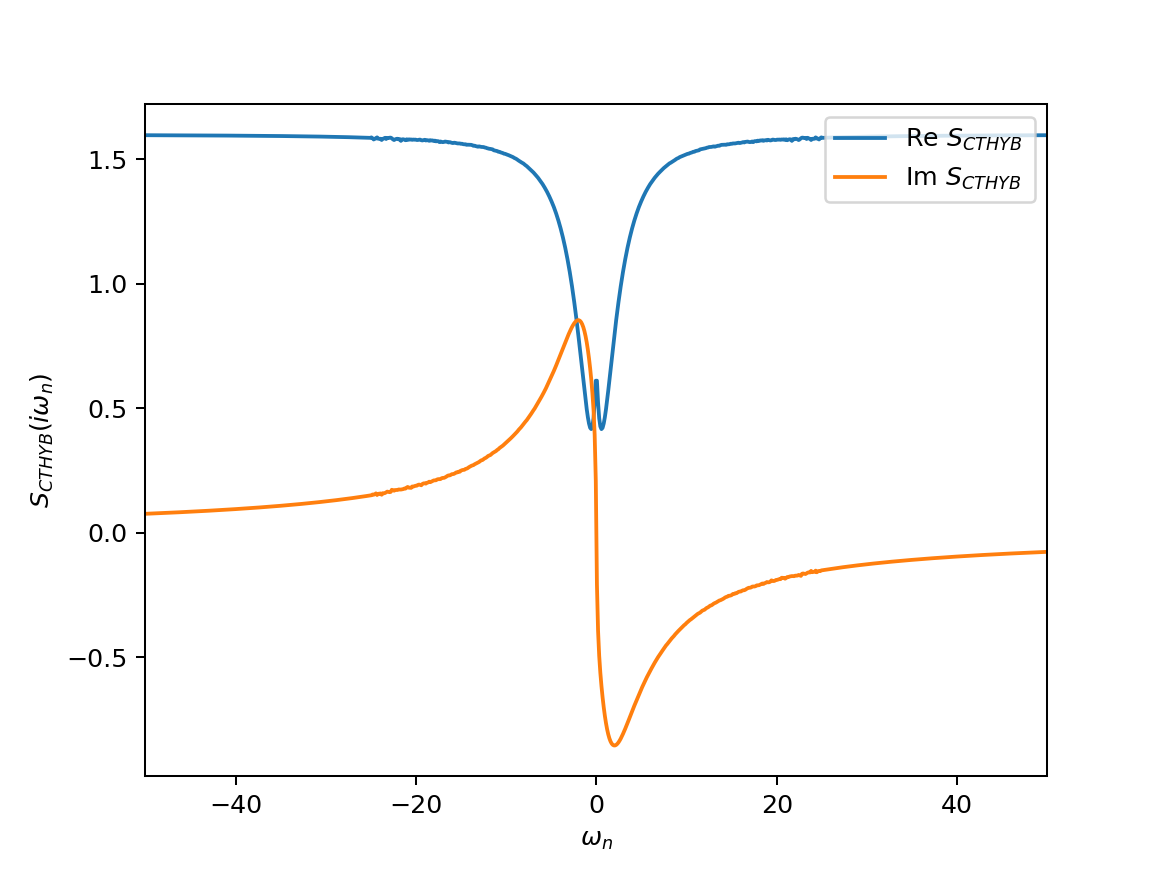

(-50, 50)

In [5]:
plt.figure(1)
oplot(S)
plt.xlim(-50,50)

Now, we define an artificial Matsubara Green's function from the self-energy:

In [ ]:
G = GfImFreq(target_shape=(), beta=50, n_points=N, name="$G_{CTHYB}$",)
G << inverse(iOmega_n-S)

<IPython.core.display.Javascript object>


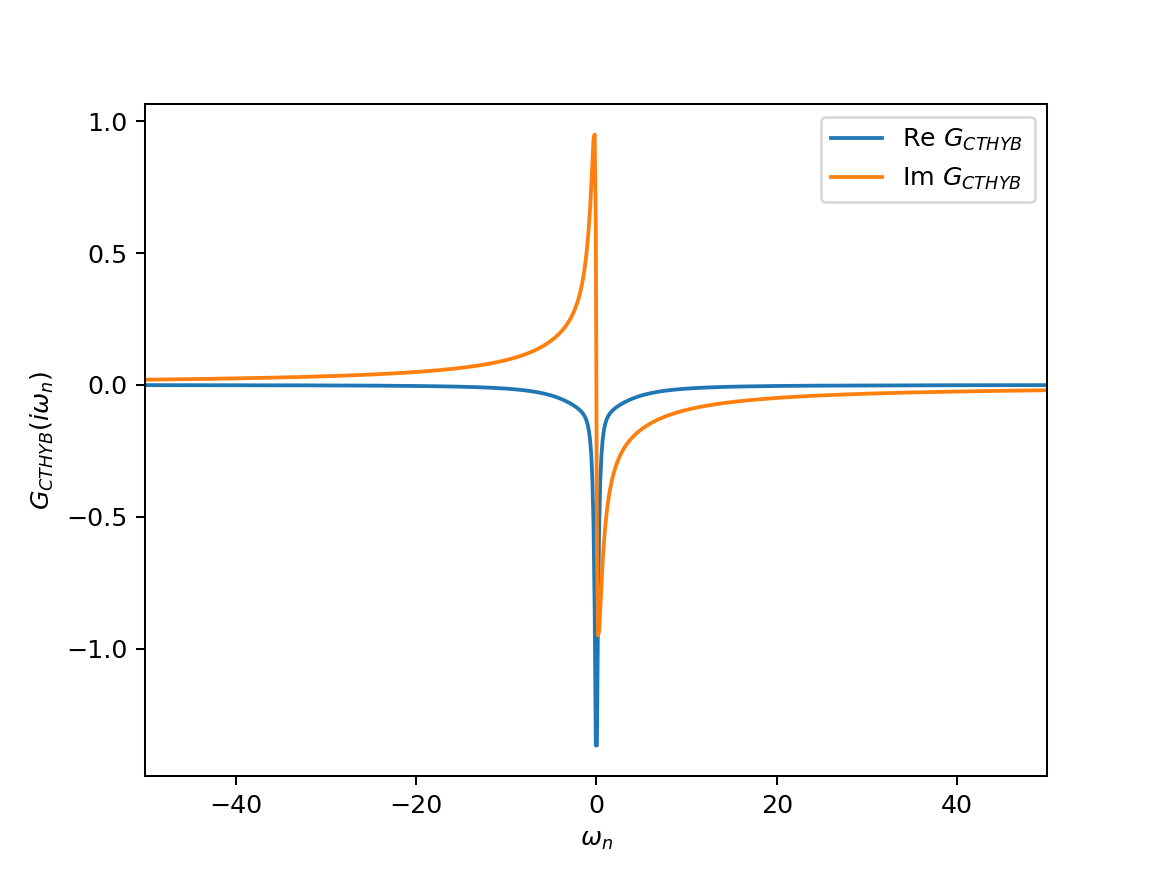

(-50, 50)

In [7]:
plt.figure(2)
oplot(G)
plt.xlim(-50,50)

Here, in the call to *compute_GfReFreq()* we can use the same computational grid as in the $\beta=20$ case. Also, instead of using explicitely `freq_step` and `spectrum_width`, we will use `comp_grid_params`, of which the first and second elements are `freq_step` and `spectrum_width`:

In [ ]:
eta = 1e-5
GR = OT.compute_GfReFreq(G, comp_grid_params=[0.02, 7.0],
         compute_Pade=True,
         eta_Pade=eta,
         displ_alpha_min_figs=False,
         interactive_mode=False,
         name="$G_{CT+ME}$")

Once the message `continuation done` is printed as the output of the previous cell, let us take a look at the output figures to ensure that the results show the correct behavior:

In [9]:
%matplotlib inline

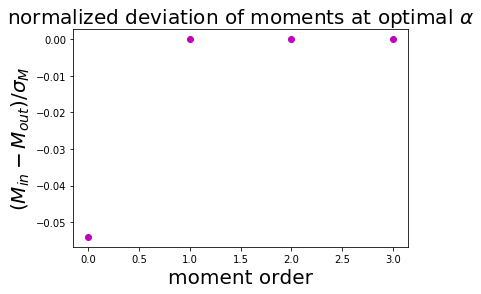

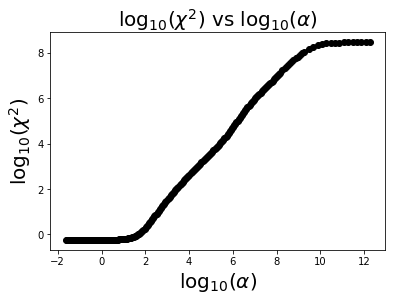

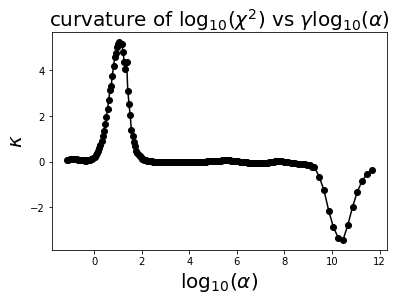

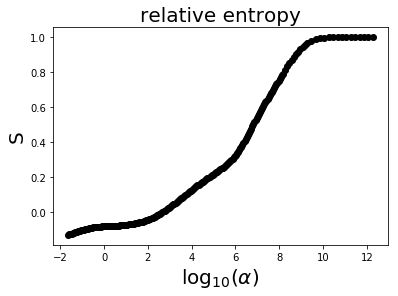

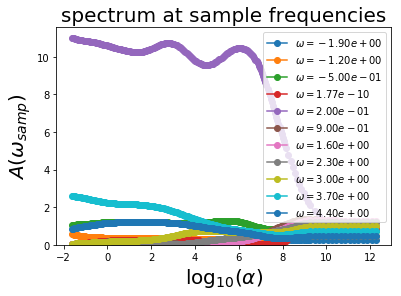

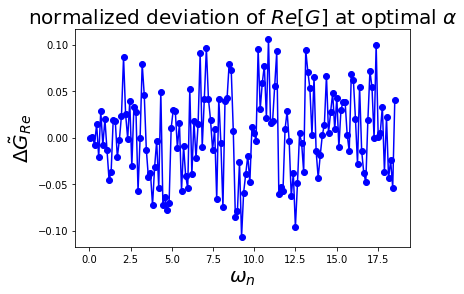

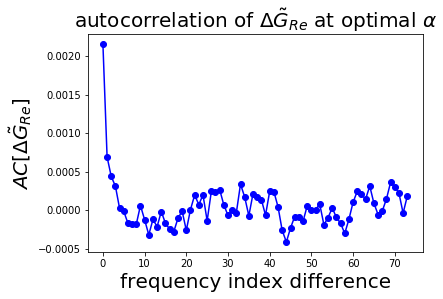

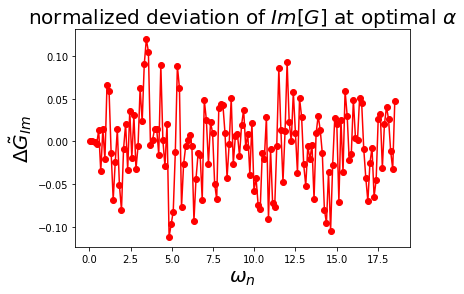

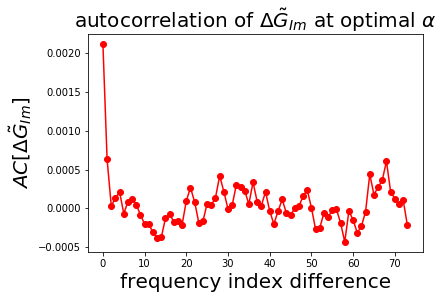

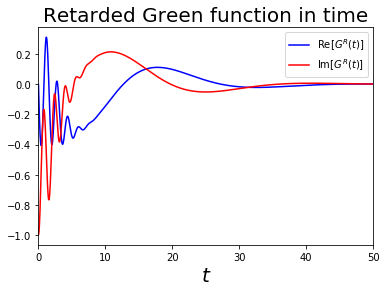

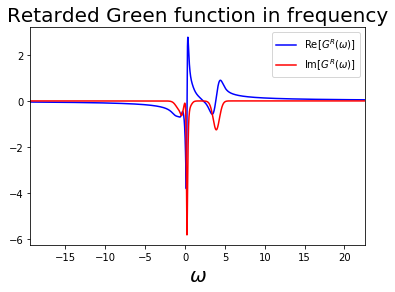

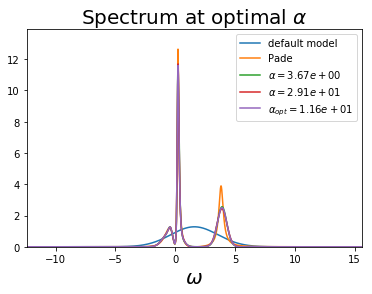

In [10]:
OT.display_figures()

Here, the curve of $\log\chi^2$ vs $\log\alpha$ should have the correct shape with the three MaxEnt regimes, the normalized deviations as functions of $\omega_n$ should look like noise and their autocorrelations, like noisy Kronecker deltas. However, because we did not provide any error, the values at 0 of the autocorrelations is arbitrary, instead of being close to 1, as we obtain when a good estimate of the standard deviation is provided. Only the qualitative properties of those curves are important for the result to be valid.

Now we define *GfReFreq* objects for the Padé and MaxEnt self-energies:

In [11]:
G_pade_data = np.loadtxt("Pade_Green_function.dat")
G_pade = GfReFreq(target_shape=(), window=(G_pade_data[0,0], G_pade_data[-1,0]), n_points=G_pade_data.shape[0])
G_pade.data.real = G_pade_data[:,1]
G_pade.data.imag = G_pade_data[:,2]
SG_pade = GfReFreq(target_shape=(), window=(G_pade_data[0,0], G_pade_data[-1,0]), n_points=G_pade_data.shape[0], name="$S_{G,CT+Pade}$")
SG_pade << Omega-inverse(G_pade)
SG = GfReFreq(target_shape=(), window=(GR.mesh.omega_min, GR.mesh.omega_max), n_points=len(GR.mesh), name="$S_{G,CT+ME}$")
SG << Omega-inverse(GR)

Green Function $S_{G,CT+ME}$ with mesh Linear Mesh of size 32769 and target_rank 0: 

and we can finally compare those results with the NRG self-energy:

In [12]:
%matplotlib notebook

<IPython.core.display.Javascript object>


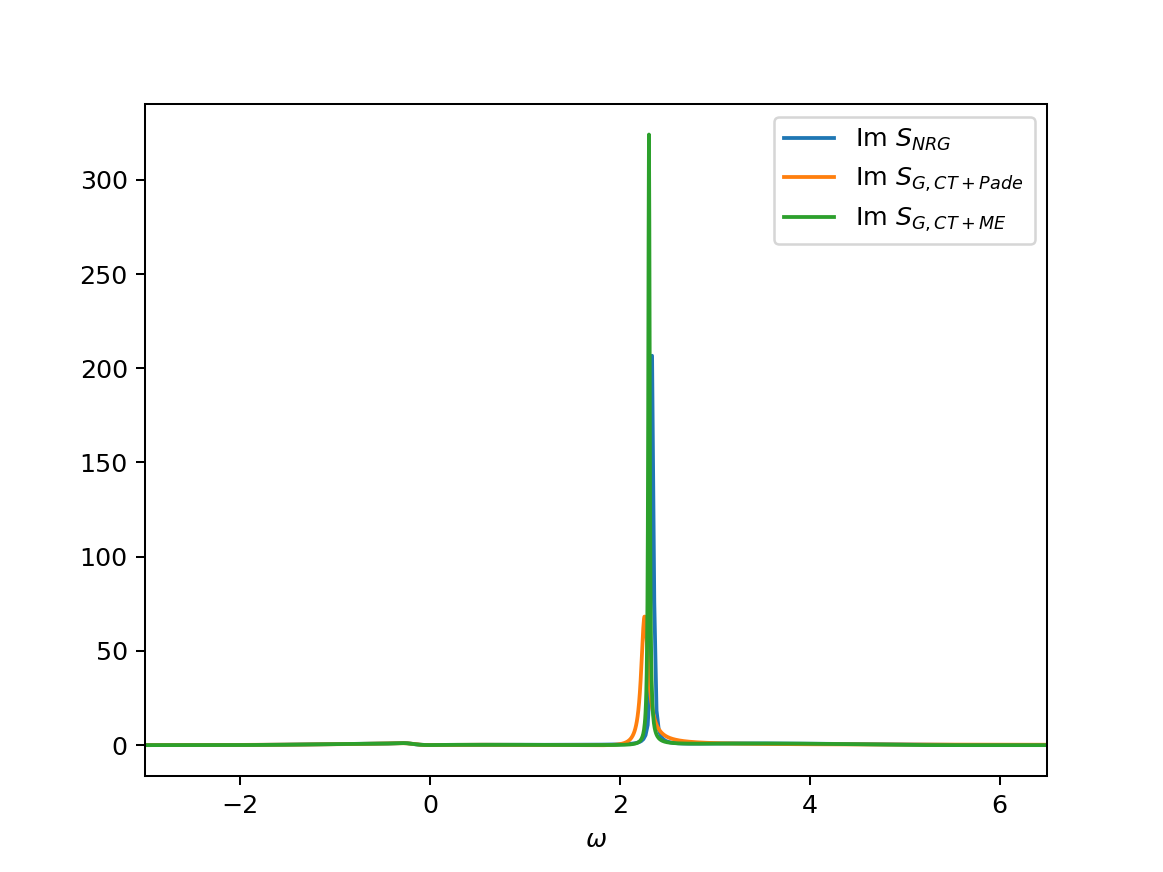

<IPython.core.display.Javascript object>


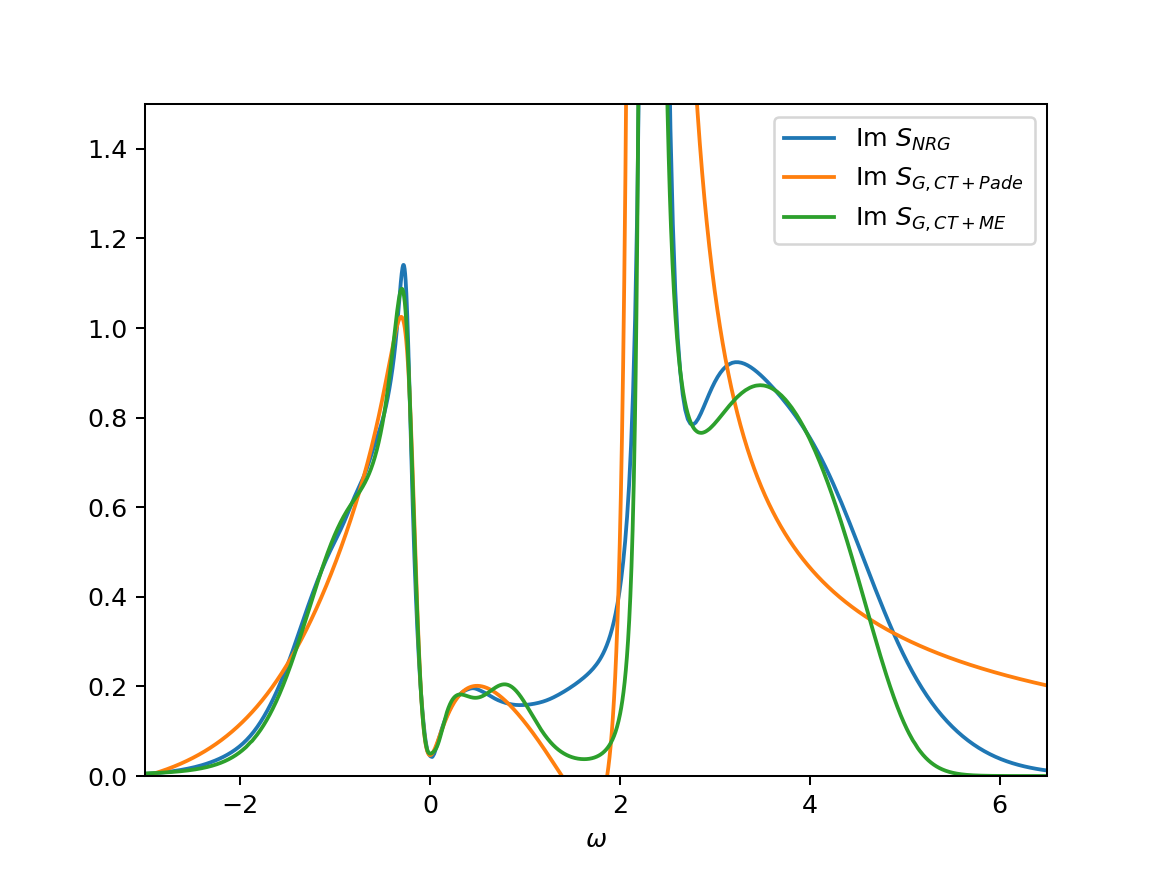

In [13]:
S_nrg = np.loadtxt("../NRG/imsigma-beta50.dat")
plt.figure(5)
plt.plot(S_nrg[:,0], -S_nrg[:,1], label='Im $S_{NRG}$')
oplot(-SG_pade.imag)
oplot(-SG.imag)
plt.ylabel('')
plt.xlim([-3,6.5])
plt.legend()
plt.figure(6)
plt.plot(S_nrg[:,0], -S_nrg[:,1], label='Im $S_{NRG}$')
oplot(-SG_pade.imag)
oplot(-SG.imag)
plt.ylabel('')
plt.xlim([-3,6.5])
plt.ylim([0,1.5])
plt.legend()

The curves Im $S_{G,CT+ME}$ and Im $S_{NRG}$ should agree well, as in the case $\beta=20$. The Padé result is close to NRG at low frequency, but becomes negative slightly below $\omega=2$ and it alos misses the secondary peak around $\omega=3.5$. Causality violation and other inaccuracies at finite frequency are frequent when using Padé approximants.

In [14]:
os.chdir("..")
su.rmtree(output_dir)